<a href="https://colab.research.google.com/github/GwenStacey/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=47.26692244151441, pvalue=5.446508723322555e-11)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
import pandas as pd

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.
df = pd.read_csv('https://math.tntech.edu/e-stat/DASL/popularkids.txt', sep='\t')
df.head()

,Gender,Grade,Age,Race,Urban.Rural,School,Goals,Grades,Sports,Looks,Money
0,boy,5,11,White,Rural,Elm,Sports,1,2,4,3
1,boy,5,10,White,Rural,Elm,Popular,2,1,4,3
2,girl,5,11,White,Rural,Elm,Popular,4,3,1,2
3,girl,5,11,White,Rural,Elm,Popular,2,3,4,1
4,girl,5,10,White,Rural,Elm,Popular,4,2,1,3


In [0]:
df.isnull().sum()

Gender         0
Grade          0
Age            0
Race           0
Urban.Rural    0
School         0
Goals          0
Grades         0
Sports         0
Looks          0
Money          0
dtype: int64

In [0]:
table_observed = pd.crosstab(df['Goals'],df['Grade'])
table_observed

Grade,4,5,6
Goals,,,
Grades,63,88,96
Popular,31,55,55
Sports,25,33,32


In [0]:
observed_w_margins = pd.crosstab(df['Goals'],df['Grade'], margins = True)
observed_w_margins

Grade,4,5,6,All
Goals,,,,
Grades,63,88,96,247
Popular,31,55,55,141
Sports,25,33,32,90
All,119,176,183,478


In [0]:
observed_w_margins['All']

Goals
Grades     247
Popular    141
Sports      90
All        478
Name: All, dtype: int64

In [0]:
observed_w_margins.T['All']

Grade
4      119
5      176
6      183
All    478
Name: All, dtype: int64

In [0]:
#Lot going on here, simplifying it will make it easier to read
np.outer(observed_w_margins['All'].values[:-1],observed_w_margins.T['All'].values[:-1]/observed_w_margins.T['All'].values[-1])

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [0]:
#Assign the long indexing to variables
goal_totals = observed_w_margins['All'].values[:-1]
goal_totals

array([247, 141,  90])

In [0]:
grade_totals = observed_w_margins.T['All'].values[:-1]
grade_totals

array([119, 176, 183])

In [0]:
expected = np.outer(goal_totals,grade_totals)/grade_totals.sum()
expected

array([[61.4916318 , 90.94560669, 94.56276151],
       [35.10251046, 51.91631799, 53.98117155],
       [22.40585774, 33.13807531, 34.45606695]])

In [0]:
table_expected = pd.DataFrame(expected)
table_expected.columns = table_observed.columns
table_expected.index = table_observed.index
table_expected

Grade,4,5,6
Goals,,,
Grades,61.491632,90.945607,94.562762
Popular,35.102510,51.916318,53.981172
Sports,22.405858,33.138075,34.456067


In [0]:
deviation = table_observed - table_expected
deviation

Grade,4,5,6
Goals,,,
Grades,1.508368,-2.945607,1.437238
Popular,-4.102510,3.083682,1.018828
Sports,2.594142,-0.138075,-2.456067


In [0]:
deviation_sq = deviation ** 2
deviation_sq

Grade,4,5,6
Goals,,,
Grades,2.275175,8.676599,2.065654
Popular,16.830592,9.509095,1.038011
Sports,6.729574,0.019065,6.032265


In [0]:
fraction = deviation_sq/table_expected
fraction

Grade,4,5,6
Goals,,,
Grades,0.037000,0.095404,0.021844
Popular,0.479470,0.183162,0.019229
Sports,0.300349,0.000575,0.175071


In [0]:
#Two ways to do the same thing
#fraction.sum().sum()
fraction.values.sum()

1.312104515381599

In [0]:
#I always keep imports in their own cells in a repl environment
from scipy.stats import chi2_contingency

In [0]:
chi2,p,df,expect = chi2_contingency(table_observed)
print(f'chi2 stat:{chi2}')
print(f'pvalue:{p}')
print(f'Degrees of Freedom:{df}')
print(f'expected freq:{expect}')


chi2 stat:1.3121045153815976
pvalue:0.8593185000807877
Degrees of Freedom:4
expected freq:[[61.4916318  90.94560669 94.56276151]
 [35.10251046 51.91631799 53.98117155]
 [22.40585774 33.13807531 34.45606695]]


#Confidence Intervals

In [0]:
import scipy.stats as stats
import numpy as np

#confidence_interval = [lower_bound,upper_bound]

coinflips = np.random.binomial(n=1,p=.51,size = 100000)
print(coinflips[:20])


[1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1]


In [0]:
stats.ttest_1samp(coinflips, 0.5)

Ttest_1sampResult(statistic=6.7308173729737675, pvalue=1.6961832078511508e-11)

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
#Let's get our favorite libraries!
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [0]:
np.set_printoptions(suppress = True)

In [0]:
#And now let's grab our data
#I already know now that we'll need to include a list of the column names,
#so we'll do that, as well as handle ?'s, as we grab it
column_names =['Class name', 'handicapped-infants', 'water-project-cost-sharing', 
            'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
            'el-salvador-aid', 'religious-groups-in-schools',
            'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
            'immigration', 'synfuels-corporation-cutback', 'education-spending',
            'superfund-right-to-sue', 'crime', 'duty-free-exports',
            'export-administration-act-south-africa']
voting_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                        header = None, names = column_names, na_values='?')

In [4]:
#Now we'll take a quick look
voting_df.head()

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [18]:
#As before, we're seeing strings, let's format
voting_df.replace(['y','n'],[0,1], inplace = True)
voting_df.head()

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0
1,republican,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
2,democrat,NaN,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
3,democrat,1.0,0.0,0.0,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,democrat,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0


In [19]:
voting_df.dtypes

Class name                                 object
handicapped-infants                       float64
water-project-cost-sharing                float64
adoption-of-the-budget-resolution         float64
physician-fee-freeze                      float64
el-salvador-aid                           float64
religious-groups-in-schools               float64
anti-satellite-test-ban                   float64
aid-to-nicaraguan-contras                 float64
mx-missile                                float64
immigration                               float64
synfuels-corporation-cutback              float64
education-spending                        float64
superfund-right-to-sue                    float64
crime                                     float64
duty-free-exports                         float64
export-administration-act-south-africa    float64
dtype: object

In [0]:
imm_r = voting_df[voting_df['Class name']=='republican']['immigration']
imm_d = voting_df[voting_df['Class name']=='democrat']['immigration']

In [21]:
_, pvalue = stats.ttest_ind(imm_r,imm_d, nan_policy = 'omit')
print(pvalue)

0.08330248490425066


In [0]:
voting_df.std()

Class name                                0.487440
handicapped-infants                       0.497222
water-project-cost-sharing                0.500632
adoption-of-the-budget-resolution         0.491140
physician-fee-freeze                      0.493721
el-salvador-aid                           0.500574
religious-groups-in-schools               0.480124
anti-satellite-test-ban                   0.495985
aid-to-nicaraguan-contras                 0.494750
mx-missile                                0.500605
immigration                               0.500563
synfuels-corporation-cutback              0.481252
education-spending                        0.494690
superfund-right-to-sue                    0.500516
crime                                     0.491806
duty-free-exports                         0.495327
export-administration-act-south-africa    0.390752
dtype: float64

In [0]:
imm_mean = np.mean(voting_df['immigration'])
U_range = 1.96
se_imm = stats.sem(voting_df['immigration'], nan_policy = 'omit')

In [24]:
np.mean(voting_df['immigration'])

0.4953271028037383

In [26]:
#Calculating our upper and lower limit
UL = imm_mean + U_range*se_imm
LL = imm_mean - U_range*se_imm
print(UL,LL)

0.5427505556066324 0.4479036500008442


In [0]:
def plot_confidence(df, std_norm_table):
  #Insure data is formatted in a way that will allow the mean function to be 
  #called on all subsequent columns
  labels = df.columns
  means = []
  confidence = []
  columns = list(df)
  for i in columns:
    means.append(np.mean(df[i]))
    
  for i in columns:
    percentage = voting_df[i].value_counts()/voting_df.shape
    std_error = stats.sem(voting_df[i], nan_policy='omit')
    upper_lower = percentage[1] + (1.96*std_error),percentage[1] - (1.96*std_error)
    confidence.append(upper_lower)
    
  y_r = [means[i] - confidence[i][1] for i in range(len(confidence))]
  plt.bar(range(len(means)), means, yerr=y_r, alpha=0.2, align='center')
  plt.axhline(0.5)

  plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], labels, rotation='vertical')

  plt.suptitle("Odds of a 'Yes' Vote")
  plt.title('95% Confidence')
  plt.ylabel('Percentage')
  plt.xlabel('The Issues')

  plt.show();
    
    

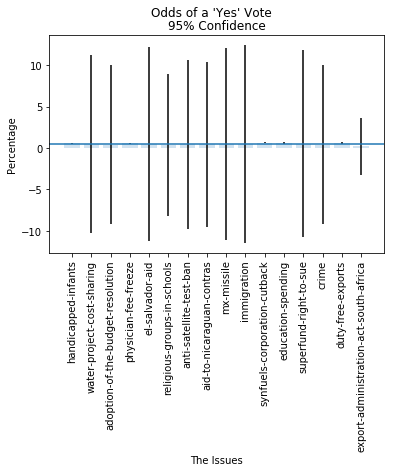

In [64]:
plot_confidence(voting_df_no_class_name, 1.96)

In [40]:
voting_df_no_class_name = voting_df.drop('Class name', axis = 1)
voting_df_no_class_name.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
2,NaN,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0


In [28]:
voting_df.columns

Index(['Class name', 'handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

In [41]:
columns = list(voting_df_no_class_name)
columns

['handicapped-infants',
 'water-project-cost-sharing',
 'adoption-of-the-budget-resolution',
 'physician-fee-freeze',
 'el-salvador-aid',
 'religious-groups-in-schools',
 'anti-satellite-test-ban',
 'aid-to-nicaraguan-contras',
 'mx-missile',
 'immigration',
 'synfuels-corporation-cutback',
 'education-spending',
 'superfund-right-to-sue',
 'crime',
 'duty-free-exports',
 'export-administration-act-south-africa']

In [59]:
confidence_int = []
for i in columns:
  percentage = voting_df[i].value_counts()/voting_df.shape
  std_error = stats.sem(voting_df[i], nan_policy='omit')
  upper_lower = percentage[1] + (1.96*std_error),percentage[1] - (1.96*std_error)
  confidence_int.append(upper_lower)
confidence_int

[(0.5899132335518289, 0.49514423771253907),
 (11.343996834966477, 11.244238459151171),
 (10.105573177588944, 10.012073881234585),
 (0.6148114692783037, 0.5208207146297422),
 (12.283168079281738, 12.187420156012378),
 (8.986877530984057, 8.895475410192415),
 (10.753261143993216, 10.658503561889136),
 (10.517905262749832, 10.423271207838404),
 (12.165928051923743, 12.069366065723315),
 (12.518011688097012, 12.423164782491224),
 (0.6532549366657648, 0.560538166782511),
 (0.5838711730931091, 0.4873931947229829),
 (11.871978067595272, 11.775080755934141),
 (10.047147868459325, 9.952852131540675),
 (0.583755021737101, 0.48750934607899105),
 (3.6891550427509125, 3.604962604307911)]

In [54]:
voting_df['immigration'].value_counts()

0.0    216
1.0    212
Name: immigration, dtype: int64

In [42]:
means=[]
for i in columns:
  means.append(np.mean(voting_df[i]))
means

[0.557919621749409,
 0.49612403100775193,
 0.4033018867924528,
 0.5825471698113207,
 0.49523809523809526,
 0.3584905660377358,
 0.4323040380047506,
 0.4238095238095238,
 0.49878934624697335,
 0.4953271028037383,
 0.6376811594202898,
 0.5767326732673267,
 0.4902439024390244,
 0.40669856459330145,
 0.5724815724815725,
 0.18731117824773413]

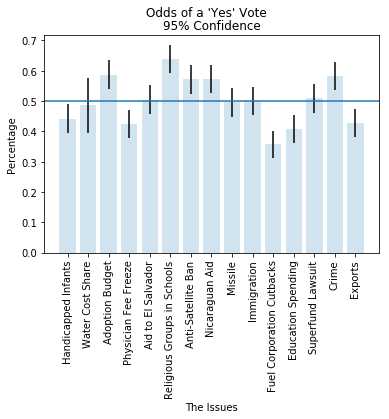

In [27]:
import matplotlib.pyplot as plt

labels = ["Handicapped Infants",
         "Water Cost Share",
         "Adoption Budget",
         "Physician Fee Freeze",
         "Aid to El Salvador",
         "Religious Groups in Schools",
         "Anti-Satellite Ban",
         "Nicaraguan Aid",
         "Missile",
         "Immigration",
         "Fuel Corporation Cutbacks",
         "Education Spending",
         "Superfund Lawsuit",
         "Crime",
         "Exports"]

means = [0.442396, 0.486175, 0.587558, 0.423963, 0.504608, 0.638249, 0.571429,
        0.573733, 0.495392, .5, 0.357143, 0.407834, 0.509217, 0.582949, .426267]

confidence = [(0.48912427, 0.39566773), (0.48912459, 0.39566804), (0.63387261, 0.54124339),
            (0.47045737, 0.37746863), (0.55164751, 0.45756849), (0.68345657, 0.59304143),
            (0.61798801, 0.52486999), (0.62026021, 0.52720579), (0.54243151, 0.44835249),
            (0.54704151, 0.45295849), (0.40222358, 0.31206242), (0.4540694, 0.3615986),
            (0.55625051, 0.46218349), (0.62933865, 0.53655935), (0.47279421, 0.37973979)]

y_r = [means[i] - confidence[i][1] for i in range(len(confidence))]
plt.bar(range(len(means)), means, yerr=y_r, alpha=0.2, align='center')
plt.axhline(0.5)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], labels, rotation='vertical')

plt.suptitle("Odds of a 'Yes' Vote")
plt.title('95% Confidence')
plt.ylabel('Percentage')
plt.xlabel('The Issues')

plt.show();

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)

#Notes for later


When determining upper and lower limits, the standard normal table is how we determine what to multiply by the standard deviation. We do that by determining what we want our confidence interval to be, then finding the upper value on the table.
